## Importing relevant libaries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass

# Libraries for implementing the VQD algorithm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler
from qiskit.primitives import Estimator as EstimatorOld
from qiskit_aer import AerSimulator
from qiskit_algorithms.utils import algorithm_globals
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_algorithms.eigensolvers import EigensolverResult, VQD
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

# Import classical optimizers
from qiskit_algorithms.optimizers import SPSA, P_BFGS, COBYLA, IMFIL, SNOBFIT, NELDER_MEAD, SLSQP, NFT, ADAM, POWELL, GradientDescent, BOBYQA

# Import Statevector and SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Statevector

# Import noise models
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Import a fake backend and Qiskit simulators and/or noise libraries
from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import Estimator as AerEstimator 
# from qiskit_aer.noise import NoiseModel

## Extracting real backend to run experiments on

In [3]:
# ## Import Qiskit Runtime Services
# service = QiskitRuntimeService(channel = "ibm_quantum", token = '38c70f7ef237498aad04c406737c00c90ffa6b812ac9fb93127aae31bf98111026e16ace36260d23682a877d9a8f832499b2069b791e4a32173eecd92f5eee07') # or on the cloud
# backend = service.backend('ibm_kyiv') # load preferred backend

## Import a fake backend instead (mimics the behavior of a real backend)
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeMontrealV2, FakeGuadalupeV2, FakeManila

# Use a fake backend
backend = FakeManilaV2()

## Constructing the FPE operator

In [7]:
## Classical implementation
"""
Purpose: 
    Find the analytical solution given the input parameters
Input: 
    x: array representing the x coordinates over which the solution is to be found
    a, Γ: parameters for the Ornstein-Uhlenbeck equation
Output:
    y: array of the value of the analytical solution over x
"""

def OrnsteinUhlenbeck(x, a = 1, gamma = 1):
    y = np.sqrt(a/(2*np.pi*gamma)) * np.exp((-a * x ** 2)/(2*gamma))
    
    return y

"""
Purpose:
    Calculate the weighted Hermite polynomials using recursive relations up to H_n
Input:
    n: the highest number of Hermite polynomials to be evaluated at
    x: the value of x at which the weighted Hermite polynomials are to be evaluated
Output:
    Hermite: the value of the weighted Hermite polynomials
Example: HermiteSeries(2, 4) -> [H_0(4), H_1(4), H_2(4)]
"""

def HermiteSeries(n, x):
    Hermite = np.zeros((1, n+1))
    Hermite[0][0] = 1.0 * np.exp(-x**2/2)
    Hermite[0][1] = 2.0 * x *np.exp(-x**2/2)
    
    for ni in range(1, n):
        Hermite[0][ni+1] = 2*x*Hermite[0][ni] - 2*ni*Hermite[0][ni-1]
    
    return Hermite

"""
Purpose:
    Reconstruct the functions represented by the coefficients of weighted Hermite polynomials in spatial coordinates
Input:
    x: array containing the x values over which the function is to be evaluated
    coefficients: the coefficients corresponding to the Hermite polynomials (should be zero-mode of the operator)
    nmax: the highest order of weighted Hermite polynomials used
    s: the scaling factor
Output:
    y: the reconstruction
"""

def project(x, coefficients, nmax, s):
    
    y = np.zeros(x.shape)
    
    for i in (range(len(x))):
        x0 = s*x[i]
        hermite_values = HermiteSeries(nmax, x0)
        y[i] += np.dot(hermite_values, coefficients)
        
    return (x, y)

"""
Purpose:
    Normalize the PDF so that the area under the curve is 1
Input:
    x, y: arrays representing the unnormalized
Output:
    (x, y): normalized PDF
"""

def normalize(x, y):
    dx = x[1] - x[0]
    sum = 0
    
    for i in range(len(x)):
        sum = sum + (y[i] * dx)
    
    y = y/sum
    
    return (x, y)

"""
Purpose:
    Calculate the RMS
Input:
    y_op, y: the y values generated by the operator and the analytical solution
Output:
    RMS
"""

def rms_diff(y_op, y):
    return np.sqrt(np.sum((y_op-y)**2)/len(y))

"""
Purpose:
    Find s given a and Γ such that the projection in Hermite space is just H_0
Input:
    a, Γ: parameters for Ornstein-Uhlenbeck
Output:
    s
"""

def special_s(a, gamma):
    return np.sqrt(a/gamma)

def euler_representation(z):
    A = abs(z)
    phase = math.atan(z.imag/z.real)
    
    return A, phase

def generate_positive_semidefinite_matrix(eigenvalues):
    ## Function to transform the FPE operator to the Hermite basis and return a finite truncated matrix for the ...
    ## ... FPE operator
    
    n = len(eigenvalues)
    s = np.diag(eigenvalues)
    q, _ = la.qr(np.random.rand(n, n))
    semidef = np.dot(np.transpose(q), s)
    semidef = np.dot(semidef, q)
    
    return semidef

def normalize_probability(y, dx):
    ## Function to return a normalized PDF 
    
    total = np.sum(y) * dx
    y = y / total
    
    return y

def perturbed_ornstein_uhlenbeck(x0, a = 1, gamma = 1, c = 0, shift = 0):
    ## Function to compute the exact solution to the perturbed Ornstein-Uhlenbeck equation
    
    assert len(x0) > 1, "Error: x0 should be a vector"

    x = x0 - shift
    y = np.exp(-a*x**2 /(2*gamma) - c*x**4 /(4*gamma))
    dx = x[2] - x[1]
    
    y = normalize_probability(y, dx)
    
    return y

def special_L(a, gamma):
    ## Function to compute the characteristic length scale
    
    return np.sqrt(a/gamma)

def delta(N, n):
    ## Function to implement the Kronecker delta function
    
    if N == n:
        return 1
    else:
        return 0
    
def matrix_element(N, n, L):
    # Function to compute the matrix elements of the position operator
    
    value = L/np.sqrt(2) * (np.sqrt(n) * delta(N, n-1) + np.sqrt(n+1) * delta(N, n+1))
    
    return value

def create_position(nmax, L):
    # Function to construct the position operator
    
    op = np.zeros((nmax + 1, nmax + 1))
    
    for N in range(nmax+1):
        row = N
        for n in range(nmax+1):
            col = n
            op[row, col] = matrix_element(N, n, L)
            
    return op

def f(N,n):
    return 0.5*( np.sqrt(n*(n-1))*delta(N,n-2) + delta(N,n) - np.sqrt((n+1)*(n+2))*delta(N,n+2))

def g(N,n, L):
    return (0.5 / L**2)*( np.sqrt(n*(n-1))*delta(N,n-2) - (2*n+1)*delta(N,n) + np.sqrt((n+1)*(n+2))*delta(N,n+2))

def t(N, n, L):
    val1 = np.sqrt(n*(n-1)*(n-2)*(n-3))*delta(N, n-4)
    val2 = (2*n+2)*np.sqrt(n*(n-1))*delta(N, n-2)
    val3 = (6*n+3)*delta(N, n)
    val4 = -2*n*np.sqrt((n+1)*(n+2))*delta(N, n+2)
    val5 = -1*np.sqrt((n+1)*(n+2)*(n+3)*(n+4))*delta(N, n+4)

    return (L**2/4)*( val1 + val2 + val3 + val4 + val5 )

def element_perturbed(N, n, L, a, c, gamma):
    ## Function to compute the matrix elements of the finite truncated matrix for the FPE operator (in the Hermite basis)
    
    return -(a*f(N,n) + c*t(N, n, L) + gamma*g(N, n, L))

def create_operator_perturbed(nmax, L, a, c, gamma):
    ## Function to generate the FPE operator matrix in the Hermite basis
    op = np.zeros((nmax+1, nmax+1))
    
    for N in range(nmax+1):
        row = N
        for n in range(nmax+1):
            col = n
            op[row, col] = element_perturbed(N, n, L, a, c, gamma)
    
    """
    if np.any(np.nan, op):
        print("There's an nan in the operator")
    elif np.any(np.inf, op):
        print("There is an inf in the operator")
    """

    return op

def state_n(nmax, x0, L):
    ## Function to compute the Hermite polynomials upto the order specified by nmax
    
    assert L > 0, "Error (state_n): input L must be greater than or equal to 0"

    states = np.zeros(nmax + 1)
    x = x0 / L

    states[0] = np.sqrt(L / np.sqrt(1/np.pi))* 1.0 * np.exp(-x**2/2)

    if nmax > 0:
        states[1] = np.sqrt(L / np.sqrt(1/np.pi))* (1/np.sqrt(2)) * 2.0 * x * np.exp(-(x**2)/2)
    
    for ni in range(2, nmax + 1):
        states[ni] = ((np.sqrt(2)*x) / np.sqrt(ni))*states[ni-1] - (ni-1)/np.sqrt((ni)*(ni-1))*states[ni-2]

    return states

def integrate_eigenvector(x0, y, nmax, L):
    ## Function to compute the coefficients corresponding to the calculated Hermite polynomials by numerical integration
    ## Note: here, we use the left-hand integration method
    
    dx = x0[2] - x0[1]
    eigenvector = np.zeros(nmax + 1)

    for i in range(len(x)):

        states = state_n(nmax, x0[i], L)
        states = states * y[i] * dx

        eigenvector = eigenvector + states
        
    return {"eigenvector" : eigenvector, "dx" : dx, "nmax" : nmax, "x0" : x0, "L" : L}

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))
    
    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]
    
    return op_new

def reconstruct_eigenvector(cache, normalize = True, only_even = False):
    ## Function to reconstruct the PDF using the cache obtained previously
    
    eigenvector = cache["eigenvector"]
    nmax = cache["nmax"]
    x0 = cache["x0"]
    dx = cache["dx"]
    L = cache["L"]
    
    if not only_even:
        eigenvector = cache["eigenvector"]
    else:
        eigenvector_old = cache["eigenvector"]
        eigenvector = np.zeros(nmax + 1)
        
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]

    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    if normalize:   
        y = normalize_probability(y, dx)
        
    return (x0, y)

def find_zeromode(op_nonhermitian, nmax, x0, dx, L, which = "single", only_even = False):
    ## Function to compute the zeromode, its position, and the eigenvalue corresponding to the zeromode
    
    assert which == "nonhermitian" or which == "single", "Error: currently only supports which = {\"nonhermitian\", \"single\"}"
    
    if only_even:
        op_processed = make_operator_even(op_nonhermitian)
    else:
        op_processed = op_nonhermitian
        
    if which == "nonhermitian":
        op = op_processed
    elif which == "single":
        op = np.dot(np.transpose(op_processed), op_processed)

    eigenvalues, eigenvectors = la.eig(op)

    index = np.argmin(np.real(eigenvalues)**2)

    min_eigenval = eigenvalues[index]
    
    zeromode = eigenvectors[:, index]

    return {"operator" : op, "which" : which, \
            "eigenvector" : np.real(zeromode), "index" : index, "eigenvalue" : np.real(min_eigenval), \
            "nmax" : nmax, "x0" : x0, "dx" : dx, "L" : L, "spectrum" : eigenvalues, "P" : eigenvectors}

def rms_diff(y0, y, sigdigits = 0):
    ## Function to compute the RMS difference between the analytically computed PDF and the one ...
    ## ... obtained using the FPE operator
    
    assert len(y0) == len(y), "Error: the length of y0 and y should be the same"
    diff = np.sum((y0-y)**2)/len(y0)
    
    return np.sqrt(diff)

def analyze_collapse(initial_state, P, index):
    num_basis = P.shape[1]
    coefficients = np.zeros((num_basis, ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        coefficients[i] = np.dot(basis, initial_state)

    normalized_coefficients = normalize_eigenvector(coefficients)

    reconstruction = np.zeros((P.shape[0], ))

    for i in range(num_basis):
        basis = P[:, i]
        basis = normalize_eigenvector(basis)

        added_vector = coefficients[i] * basis
        reconstruction = reconstruction + added_vector

    probability = normalized_coefficients ** 2
    
    probability_zeromode = probability[index]
    assert np.sum(probability) - 1 < 0.00001, "Error: unity normalization of probability is not observed"

    print("The initial_state is: ")
    print(initial_state)
    print()

    print("The coefficient expansion is: ")
    print(coefficients)
    print()

    print("The normalized coefficient expansion is: ")
    print(normalized_coefficients)
    print()

    print("The reconstructed vector is: ")
    print(reconstruction)
    print()

    print("The probability of collapsing into each eigenvector is: ")
    print(probability)
    print()

    print("The probability of collapsing into the zeromode is: ")
    print(probability_zeromode)
    print()
    
    return probability_zeromode, probability

def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)

    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

def expect_value(zeromode, matrix):
    
    value = np.dot(matrix, zeromode)
    expect = np.dot(np.transpose(zeromode), value)
    
    return expect

## Helper functions

In [10]:
def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

def make_operator_even(op):
    op_new = np.zeros((op.shape[0]//2, op.shape[1]//2))

    for row in range(op_new.shape[0]):
        for col in range(op_new.shape[1]):
            op_new[row, col] = op[row*2, col * 2]

    return op_new

def get_pdf(n, x, dx, L, shift, zeromode_qpe, normalize = True, make_even = False):
    # Function to construct the ground state PDF using the VQSVD zeromode
    
    if not make_even:
        eigenvector = zeromode_qpe
    else:
        eigenvector_old = zeromode_qpe
        eigenvector = np.zeros(n + 1)
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]
            
    x0 = x - shift
    
    # Computing the PDF
    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    
    if normalize:
        y = normalize_probability(y, dx)

    return x0, y

def compute_expectation_x_squared_simpson(x, y, n):
    """
    Computes the expectation value of x^2 using Simpson's rule for numerical integration.
    
    Parameters:
    x (array-like): Discrete values of x.
    y (array-like): Corresponding values of the probability density function (PDF) at x.
    
    Returns:
    float: The expectation value of x^2.
    """
    # Ensure x and y are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Compute x^2
    x_squared = x**n
    
    # Check if the number of intervals is even, if not make it even by truncating the last point
    if len(x) % 2 == 0:
        x = x[:-1]
        y = y[:-1]
        x_squared = x_squared[:-1]
    
    # Compute the integral using Simpson's rule
    h = (x[-1] - x[0]) / (len(x) - 1)
    integral = y[0] * x_squared[0] + y[-1] * x_squared[-1] + \
               4 * np.sum(y[1:-1:2] * x_squared[1:-1:2]) + \
               2 * np.sum(y[2:-2:2] * x_squared[2:-2:2])
    integral *= h / 3
    
    return integral

def get_pdf(n, x, dx, L, shift, zeromode_qpe, normalize = True, make_even = False):
    # Function to construct the ground state PDF using the VQSVD zeromode
    
    if not make_even:
        eigenvector = zeromode_qpe
    else:
        eigenvector_old = zeromode_qpe
        eigenvector = np.zeros(n + 1)
        for i in range(len(eigenvector_old)):
            eigenvector[2*i] = eigenvector_old[i]
            
    x0 = x - shift
    
    # Computing the PDF
    y = np.zeros(len(x0))

    for i in range(len(x0)):
        states = state_n(nmax, x0[i], L)
        y[i] += (np.dot(states, eigenvector))
    
    if normalize:
        y = normalize_probability(y, dx)

    return x0, y

# Fidelity measure 1
def get_fidelity(zeromode_classic, zeromode_vqe):
    # Function to compute the infidelity

    overlap = np.dot(np.transpose(zeromode_vqe), zeromode_classic)
    fidelity = 1 - overlap ** 2
    return fidelity

# Fidelity measure 2
def get_similarity(a, b):
    # Function to compute the similarity between 2 zeromodes
    
    numerator = np.abs(np.dot(a.conj().T, b))**2
    denominator = np.linalg.norm(a)**2 * np.linalg.norm(b)**2
    
    return numerator / denominator

def compute_errors(expect_classical, expect_quantum):

    error = np.abs(expect_classical - expect_quantum) / expect_classical
    return error

## VQE implementation

In [13]:
# VQE run for a given ansatz and optimizer
def run_vqe_ansatz_analysis(matrix, ansatz, optimizer, seed, shots, backend):

    # Get the Pauli-decomposed form of the operator
    qub_hamiltonian = SparsePauliOp.from_operator(matrix)
    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))

    # Set up the random initial point
    np.random.seed(seed)
    initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

    # Initialize the Estimator primitive with backend options
    noise_model = NoiseModel.from_backend(backend)
    
    # Get the device characteristics
    basis_gates = noise_model.basis_gates
    coupling_map = backend.coupling_map
    backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                           basis_gates = basis_gates)

    # Set up Options()
    options = Options()
    options.execution.shots = shots
    options.resilience_level = 2
    options.seed_simulator = 1
    options.optimization_level = 3

    # Initialize the Estimator primitive
    estimator = Estimator(backend = backend, options = options)

    # Logging class for VQE callback
    @dataclass
    class VQELog:
        parameters: list
        values: list
        def update(self, count, parameters, mean, _metadata):
            self.values.append(mean)
            self.parameters.append(parameters)
            
    log = VQELog([], [])
    
    # Run VQE with the given ansatz and optimizer
    vqe = VQE(estimator, ansatz, optimizer, initial_point=initial_point, callback=log.update)

    # Get the VQE results (including the eigenvalue)
    result = vqe.compute_minimum_eigenvalue(qub_hamiltonian)
    eigenvalue = result.eigenvalue.real

    # Extract the optimal parameters and construct the state vector
    optimal_params = result.optimal_point
    final_circuit = ansatz.assign_parameters(optimal_params)
    vqe_statevector = Statevector.from_instruction(final_circuit)
    vqe_statevector = np.real(vqe_statevector.data.tolist())

    # Get the number of function calls
    function_calls = result.cost_function_evals
    
    return eigenvalue, vqe_statevector, function_calls

## Computing the eigenvalue and zeromode

In [16]:
def recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth, fixed_shots, backend):
    # Infer the number of qubits from the matrix dimensions
    num_qubits = int(np.log2(matrix.shape[0]))
    
    # Initialize dictionaries to store eigenvalues and zeromodes
    eigenvalues = {}
    zeromodes = {}
    num_function_calls = {}
    
    # List of ansatz classes to evaluate
    ansatz_classes = [RealAmplitudes, TwoLocal, EfficientSU2]
    
    # Loop through each optimizer
    for optimizer in optimizers:
        optimizer_name = optimizer.__class__.__name__
        
        # Loop through each ansatz class
        for AnsatzClass in ansatz_classes:
            # Configure the ansatz with the fixed depth
            if AnsatzClass == RealAmplitudes:
                ansatz = AnsatzClass(num_qubits=num_qubits, entanglement='full', reps=fixed_depth)
            elif AnsatzClass == EfficientSU2:
                ansatz = AnsatzClass(num_qubits=num_qubits, su2_gates=['ry'], entanglement='sca', reps=fixed_depth)
            if AnsatzClass == TwoLocal:
                ansatz = AnsatzClass(num_qubits=num_qubits, rotation_blocks=['ry'], entanglement_blocks='cx', reps=fixed_depth)
            
            ansatz_name = AnsatzClass.__name__
            pair_name = f"{optimizer_name}-{ansatz_name}"
            print(f"\nRunning VQE for optimizer-ansatz pair: {pair_name}")
            
            best_eigenvalue = None
            best_zeromode = None
            best_function_calls = None
            
            # Perform 10 independent VQE runs
            for run in range(10):
                # Set a unique seed for reproducibility
                seed = run + 1
                
                # Run the VQE algorithm for the specific seed
                eigenvalue, zeromode, func_calls = run_vqe_ansatz_analysis(matrix, ansatz, optimizer, seed, fixed_shots, backend)
                
                # Log the current result
                print(f"Run {run + 1} | Eigenvalue: {eigenvalue} | Zeromode: {zeromode}")
                
                # Update the best results if the current eigenvalue is better
                if best_eigenvalue is None or np.abs(eigenvalue) < np.abs(best_eigenvalue):
                    best_eigenvalue = eigenvalue
                    best_zeromode = zeromode
                    best_function_calls = func_calls
            
            # Store the best results for this optimizer-ansatz pair
            eigenvalues[pair_name] = best_eigenvalue
            zeromodes[pair_name] = best_zeromode
            num_function_calls[pair_name] = best_function_calls
            
            print(f"Best eigenvalue for {pair_name}: {best_eigenvalue}")
            print(f"Best zeromode for {pair_name}: {best_zeromode}")
            print(f"Function calls for best result: {best_function_calls}")
    
    return eigenvalues, zeromodes, num_function_calls

## Construct the matrix and the zeromode

In [19]:
def get_zeromode(nmax, a, c, L, gamma):
    # Function to construct the matrix and get the zeromode

    #3, 5, 1, 1
    dx = 0.01
    x = np.linspace(-4, 4, int((8)/dx))
    
    ## Finding the zeromode through diagonalization
    op_nonhermitian = create_operator_perturbed(nmax, L, a, c, gamma)
    only_even = True
    
    # Matrix
    cache_diagonalization = find_zeromode(op_nonhermitian, nmax, x, dx, L, which = "single", only_even = only_even)
    matrix = cache_diagonalization['operator']

    # Get the classical zeromode
    A, P = la.eig(matrix)
    
    # Get the zeromode
    A_real = np.real(A)
    index = np.where(A_real == np.amin(A_real))[0][0]
    
    eigenvalue = A[index]
    zeromode_classic = P[:, index]
    
    zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
    zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))

    return matrix, zeromode_classic

## Quantum (VQE) analysis

### For a = 1

### For N = 2

### Get the matrix and the zeromode

In [22]:
## Get the matrix and zeromode
nmax = 3
a = 1
gamma = 1
dx = 0.01
c = 2
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[  5.765625   -21.34578596]
 [-21.34578596  79.265625  ]]

The zeromode is:
[[-0.96558703]
 [-0.26008015]]

The value of <x^2> is:
0.41050077276583463



C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Get eigenvalues and zeromodes (fix at 7000 shots)

In [46]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 7000
depth = 4

# Run VQE
eigenvalues_N_2, zeromodes_N_2, function_calls_N_2 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.1482523933569162 | Zeromode: [-0.96292019 -0.26978641]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 51.362866268002065 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 71.13309884497747 | Zeromode: [0.14807051 0.98897681]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 60.17387155292457 | Zeromode: [-0.30732551 -0.95160445]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 11.710281317324247 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 75.20034333143626 | Zeromode: [ 0.5760904  -0.81738599]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 78.55816466542285 | Zeromode: [0.01228017 0.9999246 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 9.599567609302746 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 56.224704870025654 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 10 | Eigenvalue: 6.6768815182700045 | Zeromode: [0.85214054 0.52331301]
Best eigenvalue for SLSQP-RealAmplitudes: -0.1482523933569162
Best zeromode for SLSQP-RealAmplitudes: [-0.96292019 -0.26978641]
Function calls for best result: 22

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.8474138649644019 | Zeromode: [-0.96326163 -0.26856478]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 51.14450365936423 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 71.7531013199839 | Zeromode: [0.14517643 0.98940578]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 4 | Eigenvalue: 57.3649653988994 | Zeromode: [-0.33317874 -0.94286368]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 12.485583725348775 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 75.51773249532584 | Zeromode: [ 0.5760904  -0.81738599]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 7 | Eigenvalue: 78.43618874566818 | Zeromode: [0.01531196 0.99988277]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 9.635154365167828 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 55.31151931817285 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 7.328635765803895 | Zeromode: [0.85585473 0.51721629]
Best eigenvalue for SLSQP-EfficientSU2: -0.8474138649644019
Best zeromode for SLSQP-EfficientSU2: [-0.96326163 -0.26856478]
Function calls for best result: 6

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 76.09607402959331 | Zeromode: [0.07043212 0.99751657]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: -0.47570175785982016 | Zeromode: [-0.96506  -0.262029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.1930910850485077 | Zeromode: [0.96590521 0.25889598]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.04766332578446253 | Zeromode: [-0.96550801 -0.26037334]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.18842945014194257 | Zeromode: [0.96531552 0.26108611]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: -0.15862704211740208 | Zeromode: [-0.96416901 -0.26528876]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: -0.44489332977396145 | Zeromode: [-0.96489427 -0.26263862]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.07520192115889657 | Zeromode: [0.96563631 0.25989712]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: -0.12876195847312388 | Zeromode: [-0.96536189 -0.26091459]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.06294165356367287 | Zeromode: [0.96584463 0.25912189]
Best eigenvalue for SPSA-RealAmplitudes: 0.04766332578446253
Best zeromode for SPSA-RealAmplitudes: [-0.96550801 -0.26037334]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 53.99562413422192 | Zeromode: [ 0.78307486 -0.62192746]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.6388067372079611 | Zeromode: [-0.96588515 -0.25897082]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.17573804152687345 | Zeromode: [0.96536105 0.2609177 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.06973202146554769 | Zeromode: [-0.96574083 -0.25950847]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.10230071714663325 | Zeromode: [0.96599277 0.25856907]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.6294381085088006 | Zeromode: [0.96597037 0.25865273]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.2393042622015109 | Zeromode: [0.9644184  0.26438069]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.37027061683997786 | Zeromode: [-0.96612932 -0.25805841]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: -0.14083419920908824 | Zeromode: [-0.96584374 -0.25912522]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.23842359337968588 | Zeromode: [-0.96584323 -0.25912711]
Best eigenvalue for SPSA-EfficientSU2: 0.06973202146554769
Best zeromode for SPSA-EfficientSU2: [-0.96574083 -0.25950847]
Function calls for best result: 1000


### Print the results

In [48]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_2)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_2)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_2)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': -0.1482523933569162, 'SLSQP-EfficientSU2': -0.8474138649644019, 'SPSA-RealAmplitudes': 0.04766332578446253, 'SPSA-EfficientSU2': 0.06973202146554769}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.96292019, -0.26978641]), 'SLSQP-EfficientSU2': array([-0.96326163, -0.26856478]), 'SPSA-RealAmplitudes': array([-0.96550801, -0.26037334]), 'SPSA-EfficientSU2': array([-0.96574083, -0.25950847])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 22, 'SLSQP-EfficientSU2': 6, 'SPSA-RealAmplitudes': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [50]:
# Get the zeromodes
zeromodes = list(zeromodes_N_2.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:2]
errors_spsa = relative_errors[2:4]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# For SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.013090912278208543, 0.011446512625659485]

The relative errors for SPSA are:
[0.00039631600721896936, 0.0007728943022912774]



### Run noisy experiments with TwoLocal

In [31]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 7000
depth = 4

# Run VQE
eigenvalues_N_2, zeromodes_N_2, function_calls_N_2 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.23911623534225157 | Zeromode: [-0.95880524 -0.28406429]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 10.927245196956266 | Zeromode: [-0.81012067 -0.58626317]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 57.41397115768221 | Zeromode: [ 0.76147245 -0.64819727]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 24.652820982747105 | Zeromode: [0.67756888 0.73545932]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 66.42413463043584 | Zeromode: [0.21740604 0.97608125]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 77.53325249133636 | Zeromode: [0.04043602 0.99918213]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 53.66267964610083 | Zeromode: [0.38447565 0.92313513]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 80.4250878095836 | Zeromode: [-0.0186927   0.99982528]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 63.271810282262834 | Zeromode: [-0.26507697 -0.96422726]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 31.995992093101876 | Zeromode: [ 0.92585938 -0.37786824]
Best eigenvalue for SLSQP-TwoLocal: 0.23911623534225157
Best zeromode for SLSQP-TwoLocal: [-0.95880524 -0.28406429]
Function calls for best result: 385

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 56.51738440181713 | Zeromode: [-0.76827649  0.64011814]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.41899830912209524 | Zeromode: [-0.96617756 -0.25787774]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: -0.2016330621787361 | Zeromode: [-0.96651496 -0.25661026]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.40944165356367535 | Zeromode: [-0.96512255 -0.26179852]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.026977773931655236 | Zeromode: [0.96537099 0.26088092]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: -0.151145102301399 | Zeromode: [0.96551902 0.2603325 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.3533573727050552 | Zeromode: [0.9666742  0.25600973]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.2685404495514092 | Zeromode: [-0.96469996 -0.26335144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.918722456349343 | Zeromode: [-0.96543851 -0.26063093]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.5250043291834317 | Zeromode: [0.96581304 0.25923959]
Best eigenvalue for SPSA-TwoLocal: 0.026977773931655236
Best zeromode for SPSA-TwoLocal: [0.96537099 0.26088092]
Function calls for best result: 1000


### Print the results

In [34]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_2)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_2)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_2)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': 0.23911623534225157, 'SPSA-TwoLocal': 0.026977773931655236}

The zeromodes are:
{'SLSQP-TwoLocal': array([-0.95880524, -0.28406429]), 'SPSA-TwoLocal': array([0.96537099, 0.26088092])}

The number of function calls are:
{'SLSQP-TwoLocal': 385, 'SPSA-TwoLocal': 1000}



### Computing relative errors in <x^2>

In [39]:
# Get the zeromodes
zeromodes = list(zeromodes_N_2.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:1]
errors_spsa = relative_errors[1:2]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# For SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.03224538480166884]

The relative errors for SPSA are:
[0.0010822701479935417]



### For N = 4

### Get the matrix and the zeromode

In [20]:
## Get the matrix and zeromode
nmax = 7
a = 1
gamma = 1
dx = 0.01
c = 2
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[   6.140625    -23.4671063    35.51760127   -9.22378041]
 [ -23.4671063    96.890625   -151.66269884  111.47028752]
 [  35.51760127 -151.66269884  376.140625   -354.47919269]
 [  -9.22378041  111.47028752 -354.47919269  972.890625  ]]

The zeromode is:
[[-0.97335411]
 [-0.22648723]
 [ 0.02489903]
 [ 0.02579447]]

The value of <x^2> is:
0.32868055910006333



C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Get eigenvalues and zeromodes (fix at 25_000 shots)

In [25]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 130.4382556008792 | Zeromode: [-0.88931779 -0.13658764  0.12327621  0.41864144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 198.71392020389663 | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 130.63329678696448 | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 322.0590194319243 | Zeromode: [ 0.11996722  0.20011387 -0.96286821 -0.13582015]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 245.92852819089305 | Zeromode: [-0.10658278 -0.4348135   0.79903488  0.40139829]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 531.2612858423735 | Zeromode: [-0.31069254 -0.00826443  0.40483353  0.85994864]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 564.8246625511761 | Zeromode: [ 0.33476722 -0.36658072 -0.70880692  0.50114093]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 783.7704996454273 | Zeromode: [ 0.12962998  0.44449993  0.31889351 -0.82699626]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 523.4908008552369 | Zeromode: [-0.4801357   0.47357825  0.22116505 -0.70447099]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 1080.302889552193 | Zeromode: [-0.15199025 -0.01480019 -0.57242208  0.80561335]
Best eigenvalue for SLSQP-RealAmplitudes: 130.4382556008792
Best zeromode for SLSQP-RealAmplitudes: [-0.88931779 -0.13658764  0.12327621  0.41864144]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 878.8961300021565 | Zeromode: [ 0.27293375 -0.13788895 -0.66468684  0.68167823]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 363.7202532594282 | Zeromode: [-0.79667382 -0.25771296  0.15766034 -0.52348645]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 65.9510173021391 | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 331.6832835477876 | Zeromode: [ 0.06178577 -0.15085429 -0.98643064  0.01949613]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 42.629306565590184 | Zeromode: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 767.9046361601435 | Zeromode: [ 0.01047339  0.47274916  0.32653375 -0.81839737]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 1094.1917089038404 | Zeromode: [-0.13926335 -0.07666554  0.59056695 -0.79117557]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 93.97698361189447 | Zeromode: [ 0.19977953 -0.94323116 -0.08679931  0.25073691]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 278.88743060715933 | Zeromode: [0.59447754 0.44879176 0.3085472  0.59159195]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 250.73305100456713 | Zeromode: [-0.19457046 -0.81989394 -0.10479067  0.52814315]
Best eigenvalue for SLSQP-EfficientSU2: 42.629306565590184
Best zeromode for SLSQP-EfficientSU2: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 3.035661584917662 | Zeromode: [-0.93918282 -0.3405547  -0.04199393  0.01395104]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 1.6195478609920855 | Zeromode: [-0.99139081 -0.08252983  0.09515513  0.03575732]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 28.94737306488318 | Zeromode: [-0.11418775 -0.89058009 -0.43684896 -0.05469224]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: -0.10027440005866595 | Zeromode: [ 0.99069276  0.07442355 -0.10684477 -0.03966346]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 1.9722971522630246 | Zeromode: [-0.97984217 -0.19500374  0.03619333  0.02393544]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 2.624721680260393 | Zeromode: [ 0.98942431  0.09756232 -0.09958278 -0.04005484]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 24.582766322363902 | Zeromode: [ 0.66713755 -0.59181686 -0.44228143 -0.09522308]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 14.555991187817142 | Zeromode: [ 0.79646761 -0.47162402 -0.37082779 -0.07547772]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 18.51702623706534 | Zeromode: [-0.76654467  0.51067208  0.3817173   0.07691035]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.17280875740046042 | Zeromode: [ 0.99130859  0.06073386 -0.10936778 -0.04071078]
Best eigenvalue for SPSA-RealAmplitudes: -0.10027440005866595
Best zeromode for SPSA-RealAmplitudes: [ 0.99069276  0.07442355 -0.10684477 -0.03966346]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 10.787216445784708 | Zeromode: [ 0.8865519  -0.32549168 -0.31913465 -0.07895552]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 4.625985092065662 | Zeromode: [-0.92933369  0.24523495  0.26709894  0.0696912 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 1.3335348119313721 | Zeromode: [-0.98131307 -0.18321279  0.04921778  0.03217682]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 13.954439366604806 | Zeromode: [ 0.76270377 -0.51288495 -0.38381453 -0.0889853 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 3.45038452374132 | Zeromode: [ 0.9743633   0.22272661 -0.02040764 -0.02434235]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 3.2391839459527176 | Zeromode: [ 0.98000778  0.19339339 -0.04118745 -0.02207591]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: -0.8191679967842873 | Zeromode: [ 0.98002413  0.18980225 -0.04949308 -0.03283663]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.9785026383178774 | Zeromode: [ 0.97195187  0.23172672 -0.03041813 -0.02621106]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 5.584198519220056 | Zeromode: [0.76158068 0.61416254 0.2061917  0.01685923]


C:\Users\Owner\AppData\Local\Temp\ipykernel_1940\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.9832341231237649 | Zeromode: [ 0.8835791   0.45695814  0.10224774 -0.00475623]
Best eigenvalue for SPSA-EfficientSU2: -0.8191679967842873
Best zeromode for SPSA-EfficientSU2: [ 0.98002413  0.18980225 -0.04949308 -0.03283663]
Function calls for best result: 1000


### Print the results

In [28]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': 130.4382556008792, 'SLSQP-EfficientSU2': 42.629306565590184, 'SPSA-RealAmplitudes': -0.10027440005866595, 'SPSA-EfficientSU2': -0.8191679967842873}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88931779, -0.13658764,  0.12327621,  0.41864144]), 'SLSQP-EfficientSU2': array([-0.52478359, -0.61100934, -0.54895208, -0.22343094]), 'SPSA-RealAmplitudes': array([ 0.99069276,  0.07442355, -0.10684477, -0.03966346]), 'SPSA-EfficientSU2': array([ 0.98002413,  0.18980225, -0.04949308, -0.03283663])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 11, 'SLSQP-EfficientSU2': 11, 'SPSA-RealAmplitudes': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [34]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:2]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromodes for SPSA
zeromode_1 = [-0.9798421, -0.19500374 , 0.03619333 , 0.02393544]
zeromode_2 = [ 0.97195187,  0.23172672, -0.03041813, -0.02621106]
zeromodes_spsa = [zeromode_1, zeromode_2]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[3.645467471199815, 2.939292668567651]

The relative errors for SPSA are:
[0.08805794472268279, 0.010086919840575546]



### Run noisy experiments with TwoLocal

In [23]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 102.62228590327902 | Zeromode: [-0.75634316 -0.53509875 -0.2496873   0.28155035]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 203.4486406865314 | Zeromode: [-0.15183214  0.61532166  0.75530714 -0.16684537]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 408.74169737929157 | Zeromode: [-0.25242184 -0.79790439  0.50697334 -0.20642149]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 148.56706701856473 | Zeromode: [ 0.77426162 -0.13511621  0.59122638  0.18086991]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 154.0730430811653 | Zeromode: [-0.73997911  0.13108978  0.65347361 -0.09065662]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 166.3718024542594 | Zeromode: [ 7.28374944e-02 -5.24370608e-01 -8.48369044e-01  3.60339513e-04]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 55.638276786271234 | Zeromode: [-0.91482896  0.10342244  0.37874649 -0.09456679]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 43.702942011657115 | Zeromode: [-0.04136867  0.94190469  0.32090553  0.09013223]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 34.014345750226994 | Zeromode: [-0.9373129  -0.24796204  0.09282687  0.22658887]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 30.678374443768902 | Zeromode: [-0.10326076 -0.90062881 -0.42105956 -0.03022928]
Best eigenvalue for SLSQP-TwoLocal: 30.678374443768902
Best zeromode for SLSQP-TwoLocal: [-0.10326076 -0.90062881 -0.42105956 -0.03022928]
Function calls for best result: 582

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.09248999513989986 | Zeromode: [-0.98730162 -0.13962694  0.06833407  0.03271507]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: -0.2401131845649047 | Zeromode: [ 9.53835196e-01  2.99283933e-01 -8.49507423e-04 -2.50364819e-02]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 1.662697017291336 | Zeromode: [-0.9894795  -0.03828669  0.13064901  0.04894175]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 1.072465476328091 | Zeromode: [-0.95349858 -0.29899482 -0.03556074  0.01334147]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.8900900753308179 | Zeromode: [-0.95052498 -0.30922514 -0.01376215  0.02631896]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 16.649903147002718 | Zeromode: [0.4894201  0.8062977  0.33098111 0.02834607]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 3.4695718835763145 | Zeromode: [0.79913086 0.5726101  0.18289659 0.00750813]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 1.898351980676665 | Zeromode: [ 0.98506801  0.16084274 -0.0536497  -0.02987193]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 27.360582500208608 | Zeromode: [-0.17971602  0.86063712  0.4707704   0.07335622]


C:\Users\Owner\AppData\Local\Temp\ipykernel_5716\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 2.0699561012969667 | Zeromode: [ 0.9822293   0.1776849  -0.04996396 -0.03401879]
Best eigenvalue for SPSA-TwoLocal: -0.09248999513989986
Best zeromode for SPSA-TwoLocal: [-0.98730162 -0.13962694  0.06833407  0.03271507]
Function calls for best result: 1000


### Print the results

In [26]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': 30.678374443768902, 'SPSA-TwoLocal': -0.09248999513989986}

The zeromodes are:
{'SLSQP-TwoLocal': array([-0.10326076, -0.90062881, -0.42105956, -0.03022928]), 'SPSA-TwoLocal': array([-0.98730162, -0.13962694,  0.06833407,  0.03271507])}

The number of function calls are:
{'SLSQP-TwoLocal': 582, 'SPSA-TwoLocal': 1000}



### Computing relative errors in <x^2>

In [29]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:1]
errors_spsa = relative_errors[1:2]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# For SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[3.3733129575147176]

The relative errors for SPSA are:
[0.35668781766745594]



### For a = -1

### For N = 2

### Get the matrix and the zeromode

In [42]:
## Get the matrix and zeromode
nmax = 3
a = -1
gamma = 1
dx = 0.01
c = 2
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[ 17.015625   -37.25568853]
 [-37.25568853  84.515625  ]]

The zeromode is:
[[-0.91416021]
 [-0.40535307]]

The value of <x^2> is:
0.48931145833928297



C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Get eigenvalues and zeromodes (fix at 7000 shots)

In [36]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 7000
depth = 4

# Run VQE
eigenvalues_N_2, zeromodes_N_2, function_calls_N_2 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 2.325225304225608 | Zeromode: [-0.96326163 -0.26856478]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 46.08129213141448 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 72.44437310044898 | Zeromode: [0.14517643 0.98940578]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 56.07267945825752 | Zeromode: [-0.31053661 -0.95056142]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 5.558805239431921 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 96.55867350509163 | Zeromode: [ 0.5760904  -0.81738599]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 83.98440250338442 | Zeromode: [0.01228017 0.9999246 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 23.542832256755844 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 80.61060883097512 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 2.7103398771814504 | Zeromode: [0.85585473 0.51721629]
Best eigenvalue for SLSQP-RealAmplitudes: 2.325225304225608
Best zeromode for SLSQP-RealAmplitudes: [-0.96326163 -0.26856478]
Function calls for best result: 6

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 1.6318226530983395 | Zeromode: [-0.96326163 -0.26856478]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 45.44800470740891 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 72.483572758505 | Zeromode: [0.14517643 0.98940578]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 4 | Eigenvalue: 53.989721462663454 | Zeromode: [-0.32449236 -0.94588832]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 5.252118499314294 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 97.29616537861484 | Zeromode: [ 0.5760904  -0.81738599]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 84.90183124366197 | Zeromode: [0.01228017 0.9999246 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 23.09713901545677 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 80.1967127654538 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 1.7734891510812751 | Zeromode: [0.85585473 0.51721629]
Best eigenvalue for SLSQP-EfficientSU2: 1.6318226530983395
Best zeromode for SLSQP-EfficientSU2: [-0.96326163 -0.26856478]
Function calls for best result: 6

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.7256720284066844 | Zeromode: [-0.91558194 -0.40213146]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.1036573163239396 | Zeromode: [-0.91457964 -0.40440584]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.512782379642303 | Zeromode: [0.91468503 0.40416742]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.6424008573547368 | Zeromode: [-0.91358446 -0.40664903]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.46207288538961677 | Zeromode: [0.91284602 0.40830399]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.1608862296964837 | Zeromode: [0.91464448 0.40425917]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 1.1086362719087255 | Zeromode: [0.91481431 0.4038747 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: -0.07291898813357633 | Zeromode: [-0.91415093 -0.405374  ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.407831138503159 | Zeromode: [-0.91461652 -0.40432242]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.028008042424122692 | Zeromode: [0.91571867 0.40182001]
Best eigenvalue for SPSA-RealAmplitudes: 0.028008042424122692
Best zeromode for SPSA-RealAmplitudes: [0.91571867 0.40182001]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.2866167683643859 | Zeromode: [-0.91318002 -0.40755644]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.7056395224994496 | Zeromode: [-0.91533961 -0.40268276]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: -0.15907647293468585 | Zeromode: [0.91437589 0.40486631]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.4393911900070542 | Zeromode: [-0.91511114 -0.40320168]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.0009205290044462799 | Zeromode: [0.91594952 0.40129351]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.7975519253988956 | Zeromode: [0.9155749 0.4021475]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: -0.23722095537290855 | Zeromode: [0.91419373 0.40527746]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.6710745951094701 | Zeromode: [-0.91411792 -0.40544842]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.28172720402449514 | Zeromode: [-0.91422995 -0.40519575]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23464\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.5750194194916531 | Zeromode: [-0.91441195 -0.40478486]
Best eigenvalue for SPSA-EfficientSU2: -0.0009205290044462799
Best zeromode for SPSA-EfficientSU2: [0.91594952 0.40129351]
Function calls for best result: 1000


### Print the results

In [39]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_2)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_2)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_2)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': 2.325225304225608, 'SLSQP-EfficientSU2': 1.6318226530983395, 'SPSA-RealAmplitudes': 0.028008042424122692, 'SPSA-EfficientSU2': -0.0009205290044462799}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.96326163, -0.26856478]), 'SLSQP-EfficientSU2': array([-0.96326163, -0.26856478]), 'SPSA-RealAmplitudes': array([0.91571867, 0.40182001]), 'SPSA-EfficientSU2': array([0.91594952, 0.40129351])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 6, 'SLSQP-EfficientSU2': 6, 'SPSA-RealAmplitudes': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [42]:
# Get the zeromodes
zeromodes = list(zeromodes_N_2.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:2]
errors_spsa = relative_errors[2:4]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# For SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.15146157326189755, 0.15146157326189755]

The relative errors for SPSA are:
[0.0038779990754495143, 0.004455861365886288]



### Run noisy experiments with TwoLocal

In [44]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 7000
depth = 4

# Run VQE
eigenvalues_N_2, zeromodes_N_2, function_calls_N_2 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 29.168372045390733 | Zeromode: [-0.55913767 -0.82907483]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 91.36364260374546 | Zeromode: [-0.10584397  0.99438275]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 89.917951515023 | Zeromode: [ 0.68321357 -0.73021861]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 53.884199615471985 | Zeromode: [-0.92237062  0.38630615]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 1.1561160717384098 | Zeromode: [-0.95028705 -0.3113752 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 83.42988779130167 | Zeromode: [0.00759037 0.99997119]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 47.593827972336925 | Zeromode: [0.39495479 0.91870056]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 99.2072811547436 | Zeromode: [-0.26961649  0.96296778]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 42.93066609647087 | Zeromode: [ 0.95824936 -0.28593383]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.9875881884437874 | Zeromode: [0.93922959 0.34328964]
Best eigenvalue for SLSQP-TwoLocal: 0.9875881884437874
Best zeromode for SLSQP-TwoLocal: [0.93922959 0.34328964]
Function calls for best result: 83

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.946965784744723 | Zeromode: [-0.9130456  -0.40785749]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.3536248104167008 | Zeromode: [-0.91282107 -0.40835976]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.8078230120263505 | Zeromode: [0.91503626 0.40337159]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.6509058176653113 | Zeromode: [0.91555681 0.40218868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.4372693772794136 | Zeromode: [0.91400098 0.40571197]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.8961200189551128 | Zeromode: [0.9136094  0.40659299]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.8961200189551128 | Zeromode: [0.9143425  0.40494172]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: -0.22168690859480122 | Zeromode: [0.91545055 0.40243048]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.9250485903836818 | Zeromode: [0.91411144 0.40546304]


C:\Users\Owner\AppData\Local\Temp\ipykernel_4496\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.45692848737588676 | Zeromode: [0.91629964 0.40049341]
Best eigenvalue for SPSA-TwoLocal: -0.22168690859480122
Best zeromode for SPSA-TwoLocal: [0.91545055 0.40243048]
Function calls for best result: 1000


### Print the results

In [47]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_2)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_2)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_2)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': 0.9875881884437874, 'SPSA-TwoLocal': -0.22168690859480122}

The zeromodes are:
{'SLSQP-TwoLocal': array([0.93922959, 0.34328964]), 'SPSA-TwoLocal': array([0.91545055, 0.40243048])}

The number of function calls are:
{'SLSQP-TwoLocal': 83, 'SPSA-TwoLocal': 1000}



### Computing relative errors in <x^2>

In [52]:
# Get the zeromodes
zeromodes = list(zeromodes_N_2.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:1]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromode for SPSA
zeromodes_spsa = [[0.91411144, 0.40546304]]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.06819955516776686]

The relative errors for SPSA are:
[0.00012071357080685067]



### For N = 4

### Get the matrix and the zeromode

In [23]:
## Get the matrix and zeromode
nmax = 7
a = -1
gamma = 1
dx = 0.01
c = 2
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[  17.390625    -41.49832922   41.64132563   -2.51557647]
 [ -41.49832922  138.140625   -204.49024847  154.16103593]
 [  41.64132563 -204.49024847  387.390625   -424.31381877]
 [  -2.51557647  154.16103593 -424.31381877  790.140625  ]]

The zeromode is:
[[-0.80492107]
 [-0.55178885]
 [-0.21791911]
 [-0.01193297]]

The value of <x^2> is:
0.7580435055926756



C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Get eigenvalues and zeromodes (fix at 25_000 shots)

In [26]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 91.57104638219297 | Zeromode: [-0.88931779 -0.13658764  0.12327621  0.41864144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 257.00743251486574 | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 93.7929873407891 | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 325.7228431744814 | Zeromode: [ 0.11996722  0.20011387 -0.96286821 -0.13582015]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 205.16795297534367 | Zeromode: [-0.10658278 -0.4348135   0.79903488  0.40139829]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 346.00688861348004 | Zeromode: [-0.31228562 -0.00847262  0.40183231  0.8607768 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 543.863089461053 | Zeromode: [ 0.33476722 -0.36658072 -0.70880692  0.50114093]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 657.5908874252267 | Zeromode: [ 0.12962998  0.44449993  0.31889351 -0.82699626]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 436.7937588812181 | Zeromode: [-0.48598252  0.47287655  0.21995267 -0.70130563]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 1034.2861484024158 | Zeromode: [-0.15199025 -0.01480019 -0.57242208  0.80561335]
Best eigenvalue for SLSQP-RealAmplitudes: 91.57104638219297
Best zeromode for SLSQP-RealAmplitudes: [-0.88931779 -0.13658764  0.12327621  0.41864144]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 849.2387932387309 | Zeromode: [ 0.27293375 -0.13788895 -0.66468684  0.68167823]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 345.10120557877826 | Zeromode: [-0.79667382 -0.25771296  0.15766034 -0.52348645]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 67.53383327850385 | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 332.6891799160892 | Zeromode: [ 0.0593071  -0.14953393 -0.98664212  0.0256828 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 11.153344146409797 | Zeromode: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 646.7034449323625 | Zeromode: [ 0.01047339  0.47274916  0.32653375 -0.81839737]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 1056.757996006287 | Zeromode: [-0.13926335 -0.07666554  0.59056695 -0.79117557]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 99.56636370467453 | Zeromode: [ 0.19977953 -0.94323116 -0.08679931  0.25073691]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 207.54668681934174 | Zeromode: [0.59447754 0.44879176 0.3085472  0.59159195]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 184.52507490205528 | Zeromode: [-0.19544025 -0.82146008 -0.10260631  0.52581212]
Best eigenvalue for SLSQP-EfficientSU2: 11.153344146409797
Best zeromode for SLSQP-EfficientSU2: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.7715506933975291 | Zeromode: [-0.71221499 -0.63169294 -0.30325396 -0.04184338]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 2.8123998300149573 | Zeromode: [0.58040634 0.69494997 0.4151412  0.08849182]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 9.862425998210608 | Zeromode: [-0.53190879  0.54782665  0.60677815  0.22086032]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 11.416022990761036 | Zeromode: [-0.85371004  0.21505361  0.4356701   0.18741043]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.28605411764973887 | Zeromode: [0.7538708  0.6003301  0.26523112 0.03057849]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 4.8557745202384766 | Zeromode: [-0.95533741 -0.04594637  0.25335002  0.14502805]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 5.937100632179643 | Zeromode: [-0.9641648  -0.14824296  0.17848757  0.12865634]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: -2.1927653629782515 | Zeromode: [0.7790885  0.57579343 0.24696794 0.022133  ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 13.766091825795307 | Zeromode: [-0.41453911  0.59854191  0.64439371  0.2337983 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.06999680976636746 | Zeromode: [0.77067273 0.58591176 0.24954879 0.02227898]
Best eigenvalue for SPSA-RealAmplitudes: 0.06999680976636746
Best zeromode for SPSA-RealAmplitudes: [0.77067273 0.58591176 0.24954879 0.02227898]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 2.409894699910607 | Zeromode: [-0.6929793  -0.64405805 -0.32039645 -0.04811485]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 1.2973062628510093 | Zeromode: [-0.66171239 -0.66507407 -0.34203058 -0.05318151]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 4.557277786464468 | Zeromode: [-0.29646329 -0.7603396  -0.55726268 -0.15313887]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 6.879724259875253 | Zeromode: [ 0.84666237 -0.22101739 -0.44111265 -0.19933334]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 2.606705689146594 | Zeromode: [ 0.89699358  0.42964524  0.10135306 -0.02313117]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: -0.48473641803535017 | Zeromode: [0.6672071  0.65699133 0.34579494 0.06019081]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 3.2213846486976436 | Zeromode: [-0.9401588  -0.330549    0.02131144  0.07990377]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.9154433575655716 | Zeromode: [0.82122604 0.53388925 0.20135587 0.0024222 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: -2.0085955988857123 | Zeromode: [0.77156141 0.58673109 0.24520842 0.01767639]


C:\Users\Owner\AppData\Local\Temp\ipykernel_23696\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: -0.8500605984857899 | Zeromode: [-0.95878343 -0.25976538  0.06960609  0.09171305]
Best eigenvalue for SPSA-EfficientSU2: -0.48473641803535017
Best zeromode for SPSA-EfficientSU2: [0.6672071  0.65699133 0.34579494 0.06019081]
Function calls for best result: 1000


### Print the results

In [29]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': 91.57104638219297, 'SLSQP-EfficientSU2': 11.153344146409797, 'SPSA-RealAmplitudes': 0.06999680976636746, 'SPSA-EfficientSU2': -0.48473641803535017}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88931779, -0.13658764,  0.12327621,  0.41864144]), 'SLSQP-EfficientSU2': array([-0.52478359, -0.61100934, -0.54895208, -0.22343094]), 'SPSA-RealAmplitudes': array([0.77067273, 0.58591176, 0.24954879, 0.02227898]), 'SPSA-EfficientSU2': array([0.6672071 , 0.65699133, 0.34579494, 0.06019081])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 11, 'SLSQP-EfficientSU2': 11, 'SPSA-RealAmplitudes': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [32]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:2]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromodes for SPSA
zeromode_1 = [0.7790885,  0.57579343 ,0.24696794 ,0.022133  ]
zeromode_2 = [0.77156141, 0.58673109, 0.24520842, 0.01767639]
zeromodes_spsa = [zeromode_1, zeromode_2]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[2.1470499003024335, 0.7080403792276831]

The relative errors for SPSA are:
[0.06089988578620889, 0.06086547930654207]



### Run noisy experiments with TwoLocal

In [26]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 766.677981602603 | Zeromode: [-0.21798029 -0.15832964 -0.81134485  0.51878305]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 177.8145723899029 | Zeromode: [-0.19549346  0.28672317 -0.71751132 -0.60394506]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 153.76412020206175 | Zeromode: [-0.22851199 -0.81691688  0.07103882  0.52476907]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 134.150442915333 | Zeromode: [-0.64758215 -0.48652408  0.56222186  0.16684798]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 574.7056074911703 | Zeromode: [ 0.04172037 -0.25552551  0.12360886  0.9579598 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 53.88188347824178 | Zeromode: [-0.6297718   0.49835666  0.59583925  0.00192449]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 279.69073844726665 | Zeromode: [-0.39641022  0.89409732 -0.09766208  0.18414951]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 297.5792193145249 | Zeromode: [ 0.79366286  0.36306171 -0.13367357  0.46948571]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 456.36179749887606 | Zeromode: [ 0.34838474  0.37565017  0.7737862  -0.37251837]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 28.171941914189283 | Zeromode: [-0.8895398  -0.3273007   0.13308168  0.28962471]
Best eigenvalue for SLSQP-TwoLocal: 28.171941914189283
Best zeromode for SLSQP-TwoLocal: [-0.8895398  -0.3273007   0.13308168  0.28962471]
Function calls for best result: 724

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.4193078201838838 | Zeromode: [-0.71678713 -0.62859903 -0.29853308 -0.04424333]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: -2.2207906552213927 | Zeromode: [ 0.81389875  0.54544015  0.20015113 -0.00184143]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 3.447549750030305 | Zeromode: [-0.94758371 -0.30932644  0.02346927  0.07649486]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 8.083940770385766 | Zeromode: [-0.23803731 -0.77466871 -0.56717183 -0.14677448]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 1.4202019575984153 | Zeromode: [ 0.88060963  0.4565509   0.12522046 -0.02019386]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 8.430202346940717 | Zeromode: [-0.43537683  0.60115962  0.63159519  0.22392327]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 15.343838159005783 | Zeromode: [ 0.62240705 -0.46649621 -0.58477037 -0.2302919 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 10.408508011279544 | Zeromode: [-0.15441376  0.72312017  0.64103714  0.20573041]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.14360915459024426 | Zeromode: [0.50182077 0.7327495  0.44915843 0.09752333]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17144\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: -0.03213117339303828 | Zeromode: [0.67529489 0.65027978 0.34282669 0.05985711]
Best eigenvalue for SPSA-TwoLocal: -0.03213117339303828
Best zeromode for SPSA-TwoLocal: [0.67529489 0.65027978 0.34282669 0.05985711]
Function calls for best result: 1000


### Print the results

In [29]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': 28.171941914189283, 'SPSA-TwoLocal': -0.03213117339303828}

The zeromodes are:
{'SLSQP-TwoLocal': array([-0.8895398 , -0.3273007 ,  0.13308168,  0.28962471]), 'SPSA-TwoLocal': array([0.67529489, 0.65027978, 0.34282669, 0.05985711])}

The number of function calls are:
{'SLSQP-TwoLocal': 724, 'SPSA-TwoLocal': 1000}



### Computing relative errors in <x^2>

In [32]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:1]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromode for SPSA
zeromodes_spsa = [[-0.71678713 -0.62859903 -0.29853308 -0.04424333]]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[1.2978226637318548]

The relative errors for SPSA are:
[0.6697908638922202]



### For the pure Gaussian (b = 0) case 

### For N = 2 (a = 1)

### Get the matrix and the zeromode

In [21]:
## Get the matrix and zeromode
nmax = 3
a = 1
gamma = 1
dx = 0.01
c = 0
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[  6.75       -25.45584412]
 [-25.45584412 102.75      ]]

The zeromode is:
[[-0.97042573]
 [-0.24139987]]

The value of <x^2> is:
0.40008586593679



C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Run noisy experiments with all 3 variational ansatze (fix at 7000 shots)

In [28]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 7000
depth = 4

# Run VQE
eigenvalues_N_2, zeromodes_N_2, function_calls_N_2 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.9089309999707567 | Zeromode: [-0.96326163 -0.26856478]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 67.59871282570586 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 93.8349432372681 | Zeromode: [0.14517643 0.98940578]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 79.01729946260929 | Zeromode: [-0.31053661 -0.95056142]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 17.486204855626706 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 94.6487914342241 | Zeromode: [ 0.58011671 -0.81453337]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 101.91442560403803 | Zeromode: [0.01228017 0.9999246 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 12.235959177426388 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 69.16249198983544 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 9.493798173714016 | Zeromode: [0.86111654 0.50840762]
Best eigenvalue for SLSQP-RealAmplitudes: 0.9089309999707567
Best zeromode for SLSQP-RealAmplitudes: [-0.96326163 -0.26856478]
Function calls for best result: 6

Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 16.171892012429034 | Zeromode: [ 0.9897866  -0.14255693]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 81.20414695689203 | Zeromode: [-0.28833621 -0.95752923]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 64.47304232631159 | Zeromode: [-0.43774288 -0.8991002 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 103.59430423952281 | Zeromode: [-0.473333    0.88088357]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 107.73738847703711 | Zeromode: [ 0.32282868 -0.94645742]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 99.55109684983509 | Zeromode: [-0.05597305 -0.99843228]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 10.360142110740057 | Zeromode: [ 0.99809564 -0.06168549]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 99.25373172961056 | Zeromode: [-0.0618194  -0.99808735]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 86.8294081783624 | Zeromode: [-0.22684436 -0.97393102]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 107.84449088662981 | Zeromode: [ 0.36128577 -0.93245514]
Best eigenvalue for SLSQP-TwoLocal: 10.360142110740057
Best zeromode for SLSQP-TwoLocal: [ 0.99809564 -0.06168549]
Function calls for best result: 436

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.7146248780423576 | Zeromode: [-0.96326163 -0.26856478]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 68.1462382433254 | Zeromode: [-0.40499342 -0.9143196 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 93.38962041784623 | Zeromode: [0.14517643 0.98940578]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 78.64991319198342 | Zeromode: [-0.31053661 -0.95056142]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 16.822927675777393 | Zeromode: [0.79690952 0.60409868]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 94.79422891146841 | Zeromode: [ 0.5760904  -0.81738599]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 101.51523710732263 | Zeromode: [0.01228017 0.9999246 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 11.11756585788143 | Zeromode: [-0.99685506  0.07924635]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 69.21651722176532 | Zeromode: [-0.77838865  0.62778269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 10.21378592912841 | Zeromode: [0.85585473 0.51721629]
Best eigenvalue for SLSQP-EfficientSU2: 0.7146248780423576
Best zeromode for SLSQP-EfficientSU2: [-0.96326163 -0.26856478]
Function calls for best result: 6

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.1603795748655088 | Zeromode: [-0.96538582 -0.26082601]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.7144842455313736 | Zeromode: [-0.9703651  -0.24164349]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.5307788656328256 | Zeromode: [0.96956468 0.24483533]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.1351566018223096 | Zeromode: [0.97070319 0.24028172]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 1.4382523338752833 | Zeromode: [0.97094059 0.23932063]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.4640853589405438 | Zeromode: [-0.96914928 -0.24647448]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.7732868430002284 | Zeromode: [-0.97002319 -0.24301237]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.622429700143087 | Zeromode: [-0.97043116 -0.24137806]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.2569213513963504 | Zeromode: [-0.97034329 -0.24173103]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.7059755254053073 | Zeromode: [0.97057717 0.24079026]
Best eigenvalue for SPSA-RealAmplitudes: 0.1351566018223096
Best zeromode for SPSA-RealAmplitudes: [0.97070319 0.24028172]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.15592988583275513 | Zeromode: [-0.97140065 -0.23744637]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.4129840598417047 | Zeromode: [-0.97066724 -0.24042695]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: -0.03711612511913387 | Zeromode: [0.9706622  0.24044727]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.2571354514209716 | Zeromode: [0.97028272 0.24197406]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.49011575373980065 | Zeromode: [0.9699045  0.24348564]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.2640048388637197 | Zeromode: [0.9709775  0.23917084]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.2539974185653193 | Zeromode: [0.96969564 0.24431613]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 1.510151406155778 | Zeromode: [-0.97085829 -0.23965431]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.7423165278379784 | Zeromode: [-0.97077159 -0.24000523]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: -0.026087183040061745 | Zeromode: [0.97144243 0.23727538]
Best eigenvalue for SPSA-TwoLocal: -0.026087183040061745
Best zeromode for SPSA-TwoLocal: [0.97144243 0.23727538]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 0.8028074363325644 | Zeromode: [-0.97106415 -0.23881879]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 0.98855585979247 | Zeromode: [-0.97030841 -0.24187101]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 0.8522449135768753 | Zeromode: [0.96900226 0.24705185]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.437488698439239 | Zeromode: [-0.97121449 -0.23820665]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.5966649505690427 | Zeromode: [0.97060019 0.24069748]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 0.6540178262079905 | Zeromode: [0.97060604 0.24067387]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 0.578173299315786 | Zeromode: [-0.97135342 -0.23763949]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: -0.11357846291398488 | Zeromode: [-0.9705161  -0.24103632]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.11561893961715697 | Zeromode: [0.9698919  0.24353583]


C:\Users\Owner\AppData\Local\Temp\ipykernel_17272\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 0.5499128169599459 | Zeromode: [0.97156645 0.23676706]
Best eigenvalue for SPSA-EfficientSU2: -0.11357846291398488
Best zeromode for SPSA-EfficientSU2: [-0.9705161  -0.24103632]
Function calls for best result: 1000


### Print the results

In [31]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_2)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_2)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_2)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': 0.9089309999707567, 'SLSQP-TwoLocal': 10.360142110740057, 'SLSQP-EfficientSU2': 0.7146248780423576, 'SPSA-RealAmplitudes': 0.1351566018223096, 'SPSA-TwoLocal': -0.026087183040061745, 'SPSA-EfficientSU2': -0.11357846291398488}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.96326163, -0.26856478]), 'SLSQP-TwoLocal': array([ 0.99809564, -0.06168549]), 'SLSQP-EfficientSU2': array([-0.96326163, -0.26856478]), 'SPSA-RealAmplitudes': array([0.97070319, 0.24028172]), 'SPSA-TwoLocal': array([0.97144243, 0.23727538]), 'SPSA-EfficientSU2': array([-0.9705161 , -0.24103632])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 6, 'SLSQP-TwoLocal': 436, 'SLSQP-EfficientSU2': 6, 'SPSA-RealAmplitudes': 1000, 'SPSA-TwoLocal': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [34]:
# Get the zeromodes
zeromodes = list(zeromodes_N_2.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:3]
errors_spsa = relative_errors[3:6]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# For SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.0377761635541995, 0.48871687984704343, 0.0377761635541995]

The relative errors for SPSA are:
[0.0015663155152035768, 0.005782469790802622, 0.0005091553629019643]



### For N = 4 (a = 1)

### Get the matrix and the zeromode 

In [20]:
## Get the matrix and zeromode
nmax = 7
a = 1
gamma = 1
dx = 0.01
c = 0
L = 1/2
x = np.linspace(-4, 4, int(8/dx))

# Matrix and zeromode
matrix, zeromode = get_zeromode(nmax, a, c, L, gamma)

## Print the matrix and zeromode
print('The matrix is:')
print(matrix)
print()

# Print the zeromode
print('The zeromode is:')
print(zeromode)
print()

## Compute the classical <x^2> value
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
classical_expectation = compute_expectation_x_squared_simpson(x, y, 2)

# Print the classical expectation value
print('The value of <x^2> is:')
print(classical_expectation)
print()

The matrix is:
[[   6.75        -25.45584412   18.37117307    0.        ]
 [ -25.45584412  129.75       -173.20508076   71.15124735]
 [  18.37117307 -173.20508076  448.75       -449.13249715]
 [   0.           71.15124735 -449.13249715  837.75      ]]

The zeromode is:
[[-0.92504521]
 [-0.34807967]
 [-0.14437197]
 [-0.04783967]]

The value of <x^2> is:
0.6419765393615697



C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\795971042.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eigenvector[2*i] = eigenvector_old[i]


### Run noisy experiments with RealAmplitudes and EfficientSU2 (fix at 25_000 shots)

In [24]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 102.58397949882722 | Zeromode: [-0.88931779 -0.13658764  0.12327621  0.41864144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 251.4313129744762 | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 124.0245964126803 | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 375.71128368242324 | Zeromode: [ 0.11996722  0.20011387 -0.96286821 -0.13582015]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 248.06057108323688 | Zeromode: [-0.10658278 -0.4348135   0.79903488  0.40139829]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 380.6937560939936 | Zeromode: [-0.31228562 -0.00847262  0.40183231  0.8607768 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 656.8571300958936 | Zeromode: [ 0.33476722 -0.36658072 -0.70880692  0.50114093]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 774.5249912885995 | Zeromode: [ 0.12962998  0.44449993  0.31889351 -0.82699626]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 532.3382969748242 | Zeromode: [-0.4801357   0.47357825  0.22116505 -0.70447099]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 1104.1782133291629 | Zeromode: [-0.15199025 -0.01480019 -0.57242208  0.80561335]
Best eigenvalue for SLSQP-RealAmplitudes: 102.58397949882722
Best zeromode for SLSQP-RealAmplitudes: [-0.88931779 -0.13658764  0.12327621  0.41864144]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 1 | Eigenvalue: 946.896252190654 | Zeromode: [ 0.27741416 -0.13473792 -0.66201724  0.68309608]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 347.62658064664527 | Zeromode: [-0.79667382 -0.25771296  0.15766034 -0.52348645]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 51.73605169900707 | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 409.8812711571089 | Zeromode: [ 0.0593071  -0.14953393 -0.98664212  0.0256828 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 16.399482829851387 | Zeromode: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 770.4862450793645 | Zeromode: [ 0.01047339  0.47274916  0.32653375 -0.81839737]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 1121.0557025092025 | Zeromode: [-0.13926335 -0.07666554  0.59056695 -0.79117557]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 8 | Eigenvalue: 138.27398543300498 | Zeromode: [ 0.19284524 -0.94598411 -0.0805945   0.24784934]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 181.85364236718695 | Zeromode: [0.59447754 0.44879176 0.3085472  0.59159195]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 275.45503351430375 | Zeromode: [-0.19457046 -0.81989394 -0.10479067  0.52814315]
Best eigenvalue for SLSQP-EfficientSU2: 16.399482829851387
Best zeromode for SLSQP-EfficientSU2: [-0.52478359 -0.61100934 -0.54895208 -0.22343094]
Function calls for best result: 11

Running VQE for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 2.510708027445851 | Zeromode: [-0.97014189 -0.23562545 -0.05530806 -0.01569639]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 2.875895693014897 | Zeromode: [0.93224314 0.33398642 0.13297129 0.04116343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: -0.6174339020859207 | Zeromode: [-0.96918206 -0.24036205 -0.05219247 -0.01371715]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: -1.366170998527103 | Zeromode: [-0.87260009 -0.43056989 -0.21795327 -0.07533274]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 0.6350940459876426 | Zeromode: [-0.9261199  -0.35080042 -0.13476673 -0.03284707]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 6.926117105837882 | Zeromode: [0.5368996  0.69437184 0.44265553 0.18341935]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 2.8214107389706395 | Zeromode: [0.77497972 0.54470711 0.30049856 0.1113607 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 7.943756276564162 | Zeromode: [0.51031489 0.69729174 0.46364177 0.19595725]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 5.846801772760571 | Zeromode: [-9.87796912e-01 -8.53308082e-04  1.34199061e-01  7.90388764e-02]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 2.390020728810658 | Zeromode: [-0.84678978 -0.46670246 -0.2394915  -0.08820266]
Best eigenvalue for SPSA-RealAmplitudes: -0.6174339020859207
Best zeromode for SPSA-RealAmplitudes: [-0.96918206 -0.24036205 -0.05219247 -0.01371715]
Function calls for best result: 1000

Running VQE for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 2.6615789987224474 | Zeromode: [ 0.99007523  0.12609958 -0.04823076 -0.03903489]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: -0.08945511768161651 | Zeromode: [-0.93686963 -0.3284427  -0.11597432 -0.03083256]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: -1.945770158989447 | Zeromode: [0.92610038 0.35064394 0.13430148 0.03674269]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 3.2408438522251473 | Zeromode: [ 0.9764483   0.21444943  0.01903836 -0.01406042]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.4013123182799134 | Zeromode: [0.94070305 0.31856038 0.11177395 0.03322108]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: -2.805167478038811 | Zeromode: [-0.96138681 -0.26787387 -0.06278339 -0.00610149]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: -2.2132700352200487 | Zeromode: [0.90362826 0.3878859  0.1713993  0.06018945]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 1.8085324775481837 | Zeromode: [0.92448895 0.34982378 0.14505895 0.04360525]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 1.6609898868567043 | Zeromode: [0.93755104 0.32429372 0.1200931  0.03754043]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12484\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 5.038260982988035 | Zeromode: [ 0.98047049  0.19635914  0.00612246 -0.00912299]
Best eigenvalue for SPSA-EfficientSU2: -0.08945511768161651
Best zeromode for SPSA-EfficientSU2: [-0.93686963 -0.3284427  -0.11597432 -0.03083256]
Function calls for best result: 1000


### Print the results

In [27]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': 102.58397949882722, 'SLSQP-EfficientSU2': 16.399482829851387, 'SPSA-RealAmplitudes': -0.6174339020859207, 'SPSA-EfficientSU2': -0.08945511768161651}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88931779, -0.13658764,  0.12327621,  0.41864144]), 'SLSQP-EfficientSU2': array([-0.52478359, -0.61100934, -0.54895208, -0.22343094]), 'SPSA-RealAmplitudes': array([-0.96918206, -0.24036205, -0.05219247, -0.01371715]), 'SPSA-EfficientSU2': array([-0.93686963, -0.3284427 , -0.11597432, -0.03083256])}

The number of function calls are:
{'SLSQP-RealAmplitudes': 11, 'SLSQP-EfficientSU2': 11, 'SPSA-RealAmplitudes': 1000, 'SPSA-EfficientSU2': 1000}



### Computing relative errors in <x^2>

In [30]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:2]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromodes for SPSA
zeromode_1 = [-0.9261199 , -0.35080042, -0.13476673, -0.03284707]
zeromode_2 = [0.92448895, 0.34982378, 0.14505895, 0.04360525]
zeromodes_spsa = [zeromode_1, zeromode_2]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[2.354432248224673, 1.0168477154184057]

The relative errors for SPSA are:
[0.03740142852077602, 0.005498087398765347]



### Run noisy experiments with TwoLocal (fix at 25_000 shots)

In [25]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 25_000
depth = 4

# Run VQE
eigenvalues_N_4, zeromodes_N_4, function_calls_N_4 = recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth = depth, fixed_shots = shots, \
                                                                                      backend = backend)


Running VQE for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: 65.85910894715651 | Zeromode: [ 0.78397429  0.59995069 -0.0109545   0.15913353]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 264.23913090278177 | Zeromode: [ 0.05373137 -0.34923796  0.8564045   0.37645334]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 788.410916696971 | Zeromode: [-0.34207524  0.32046956 -0.08356339  0.87937532]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 175.52123232311786 | Zeromode: [ 0.33441811  0.83172181 -0.36501426 -0.25133235]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: 23.962890743105405 | Zeromode: [0.14126308 0.8144961  0.49575722 0.26620597]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 283.5444358872662 | Zeromode: [-0.15809561  0.50959069 -0.48095354 -0.69570597]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 323.413163998274 | Zeromode: [ 0.57938847 -0.57329186 -0.34641376  0.46437372]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 81.41987446128391 | Zeromode: [ 0.13195263 -0.3111721  -0.84621744 -0.41191803]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 109.22854373680053 | Zeromode: [-0.17494402  0.9470546   0.20534928 -0.17410874]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: 1.4979313136419465 | Zeromode: [0.72240966 0.60377724 0.30403754 0.14539088]
Best eigenvalue for SLSQP-TwoLocal: 1.4979313136419465
Best zeromode for SLSQP-TwoLocal: [0.72240966 0.60377724 0.30403754 0.14539088]
Function calls for best result: 702

Running VQE for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: -0.7448700371511165 | Zeromode: [-0.8992123  -0.3953862  -0.1774729  -0.05991967]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: 1.276633833170699 | Zeromode: [0.91658398 0.36784065 0.14905227 0.04848187]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: 4.835683335286472 | Zeromode: [-0.84444848 -0.47024049 -0.24099596 -0.08775874]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: 0.720462646745105 | Zeromode: [ 0.99255689  0.09828334 -0.05767089 -0.04295654]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 5 | Eigenvalue: -0.15686709995454606 | Zeromode: [-0.94327633 -0.3126642  -0.10697598 -0.03204694]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 6 | Eigenvalue: 24.835423290164833 | Zeromode: [-0.08210771  0.77419244  0.5762369   0.24866732]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 7 | Eigenvalue: 5.143553917843732 | Zeromode: [ 0.9910812   0.01787209 -0.11284481 -0.06859075]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 8 | Eigenvalue: 0.7131068498578514 | Zeromode: [-0.97365593 -0.22362168 -0.04443657 -0.00358841]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 9 | Eigenvalue: 0.7009675588745701 | Zeromode: [0.77194241 0.54032508 0.31108346 0.12401938]


C:\Users\Owner\AppData\Local\Temp\ipykernel_16580\3532755866.py:30: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 10 | Eigenvalue: -2.0538142682770726 | Zeromode: [0.91260163 0.37399688 0.15525744 0.05638901]
Best eigenvalue for SPSA-TwoLocal: -0.15686709995454606
Best zeromode for SPSA-TwoLocal: [-0.94327633 -0.3126642  -0.10697598 -0.03204694]
Function calls for best result: 1000


### Print the results

In [28]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_N_4)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_N_4)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_N_4)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': 1.4979313136419465, 'SPSA-TwoLocal': -0.15686709995454606}

The zeromodes are:
{'SLSQP-TwoLocal': array([0.72240966, 0.60377724, 0.30403754, 0.14539088]), 'SPSA-TwoLocal': array([-0.94327633, -0.3126642 , -0.10697598, -0.03204694])}

The number of function calls are:
{'SLSQP-TwoLocal': 702, 'SPSA-TwoLocal': 1000}



### Computing relative errors in <x^2>

In [33]:
# Get the zeromodes
zeromodes = list(zeromodes_N_4.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Convert the array to real numbers if it's not a string
        zeromodes_true.append([elem.real for elem in arr.flatten()])

# Initialize
relative_errors = []

# Compute 
for zeromode in zeromodes_true:
    if zeromode != "Did not converge":
        x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
        
        # Ensure quantum_expectation is a scalar
        quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
        if isinstance(quantum_expectation, np.ndarray):
            quantum_expectation = quantum_expectation.item()  # Convert to scalar if necessary
        
        # Compute the relative error
        relative_error = compute_errors(classical_expectation, quantum_expectation)
        relative_errors.append(relative_error)
    else:
        relative_errors.append('No solution')

## Extract the relative errors for SLSQP and SPSA
errors_slsqp = relative_errors[:1]

## Print the relative errors
# For SLSQP
print('The relative errors for SLSQP are:')
print(errors_slsqp)
print()

# Get the best zeromode for SPSA
zeromodes_spsa = [[0.91658398, 0.36784065 ,0.14905227, 0.04848187]]

# Compute 
errors_spsa = []

for zeromode in zeromodes_spsa:
    x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)
    quantum_expectation = compute_expectation_x_squared_simpson(x, y, 2)
    relative_error = compute_errors(classical_expectation, quantum_expectation)
    errors_spsa.append(relative_error)

# Print the results for SPSA
print('The relative errors for SPSA are:')
print(errors_spsa)
print()

The relative errors for SLSQP are:
[0.5382034831638589]

The relative errors for SPSA are:
[0.020912119493279306]



### Comparing the performances of SLSQP and SPSA

In [3]:
# Data
slsqp_errors = [
    [0.013090912278208543, 0.03224538480166884, 0.011446512625659485],
    [3.645467471199815, 3.3733129575147176, 2.939292668567651],
    [0.15146157326189755, 0.06819955516776686, 0.15146157326189755],
    [2.1470499003024335, 1.2978226637318548, 0.7080403792276831],
    [0.0377761635541995, 0.48871687984704343, 0.0377761635541995], 
    [2.354432248224673, 0.5382034831638589, 1.0168477154184057]
]

spsa_errors = [
    [0.00039631600721896936, 0.0010822701479935417, 0.0007728943022912774],
    [0.08805794472268279, 0.35668781766745594, 0.010086919840575546],
    [0.0038779990754495143, 0.00012071357080685067, 0.004455861365886288],
    [0.06089988578620889, 0.6697908638922202, 0.06086547930654207],
    [0.0015663155152035768, 0.005782469790802622, 0.0005091553629019643], 
    [0.03740142852077602, 0.020912119493279306, 0.005498087398765347]
    
]

titles = [
    r"$a = 1, b = 2, \ell = 1/2, \Gamma = 1; N = 2 ~(7000 ~\mathrm{shots})$",
    r"$a = 1, b = 2, \ell = 1/2, \Gamma = 1; N = 4 ~(2.5 \times 10^4 ~\mathrm{shots})$",
    r"$a = -1, b = 2, \ell = 1/2, \Gamma = 1; N = 2 ~(7000 ~\mathrm{shots})$",
    r"$a = -1, b = 2, \ell = 1/2, \Gamma = 1; N = 4 ~(2.5 \times 10^4 ~\mathrm{shots})$",
    r"$a = 1, b = 0, \ell = 1/2, \Gamma = 1; N = 2 ~(7000 ~\mathrm{shots})$", 
    r"$a = 1, b = 0, \ell = 1/2, \Gamma = 1; N = 4 ~(2.5 \times 10^4 ~\mathrm{shots})$"
]

# Plot settings
fig, axes = plt.subplots(3, 2, figsize=(13, 14), dpi = 600)
markers = ['o', 's', '^']  # Solid markers for both ansatz types
colors = ['blue', 'red', 'purple']
ansatz_labels = ["RealAmplitudes", "TwoLocal", "EfficientSU2"]

# Plotting
for i, ax in enumerate(axes.flatten()):
    x_labels = ["SLSQP", "SPSA"]
    x_positions = np.arange(len(x_labels))
    
    # Plot for RealAmplitudes
    ax.scatter(x_positions - 0.1, [slsqp_errors[i][0], spsa_errors[i][0]], 
               color=colors[0], marker=markers[0], label=ansatz_labels[0], s=100)
    # Plot for TwoLocal
    ax.scatter(x_positions, [slsqp_errors[i][1], spsa_errors[i][1]], 
               color=colors[1], marker=markers[1], label=ansatz_labels[1], s=100)
    # Plot for EfficientSU2
    ax.scatter(x_positions + 0.1, [slsqp_errors[i][2], spsa_errors[i][2]], 
               color=colors[2], marker=markers[2], label=ansatz_labels[2], s=100)

    # Add gray dotted line to separate SLSQP and SPSA
    ax.axvline(x=0.5, color='gray', linestyle='dashed', linewidth=1)
    
    # Set y-axis to logarithmic scale
    ax.set_yscale('log')
    
    # Aesthetics
    ax.set_title(titles[i], fontsize=18)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=18)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel(r"$\langle x^2 \rangle_{\mathrm{relative ~error}}$", fontsize=19)
    ax.legend(fontsize=16)
    ax.grid(True)

# Add a common title
fig.suptitle('Manila machine', fontsize = 22)

# Adjust layout
plt.tight_layout(pad = 1.0)
plt.subplots_adjust(top=0.90)  
plt.savefig('Hardware noise analysis_FPE.pdf', bbox_inches = 'tight', dpi = 600)

### Taking a look at the PDFs

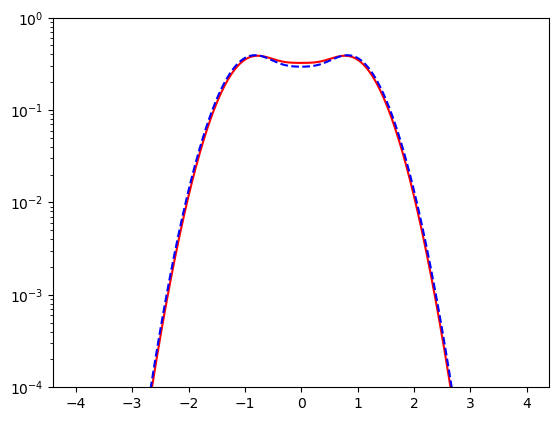

In [28]:
# Get the zeromode
classical_zeromode = [-0.80492107, -0.55178885, -0.21791911, -0.01193297]
zeromode = [0.77156141, 0.58673109, 0.24520842, 0.01767639]

# Get the parameters
a = 1
gamma = 1
c = 2
L = 1/2
nmax = 7
dx = 0.01
x = np.linspace(-4, 4, int(8/dx))

# Get the PDFs
x_classical, y_classical = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = classical_zeromode, normalize = True, make_even = True)
x, y = get_pdf(nmax, x, dx, L, shift = 0, zeromode_qpe = zeromode, normalize = True, make_even = True)

# Plot
plt.plot(x_classical, y_classical, 'r')
plt.plot(x, y, '--b')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.show()